# Lecture 3: Language Modeling Fundamentals

Lecture 3 | CMU ANLP Fall 2025 | Instructor: Sean Welleck

#### Part 1: Bigram language models

This is a notebook for [CMU CS11-711 Advanced NLP](https://cmu-l3.github.io/anlp-fall2025/) that trains and evaluates a bigram language model.


*Acknowledgements*: the content is based on Andrej Karpathy's makemore bigrams lecture ( [[youtube link](https://www.youtube.com/watch?v=PaCmpygFfXo)][[notebook]((https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb))])

## Bigram language model

\begin{align}
p(x_1, x_2, \ldots, x_T) = \prod_{t=1}^{T} p(x_t \mid x_{t-1})
\end{align}

where $ p(x_t \mid x_{t-1}) $ is the conditional probability of token $ x_t $ given the previous token $ x_{t-1} $. We use a special token `[S]` to denote the start $x_0$ and end $x_T$ of a sequence.

Let's walk through a simple example. 

In [1]:
import os
import pathlib
import sys
print(sys.version)
print("CWD:", os.getcwd())
print("names.txt exists:", pathlib.Path("names.txt").is_file())

3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]
CWD: /Users/xinkaidu/Documents/Git/online_courses_5/cmu/advancedNLP/03_lm_fundamentals
names.txt exists: True


In [10]:
data = open('names.txt').read().splitlines()
data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Our dataset consists of names. 

For simplicity, we will use character tokenization, i.e., our vocabulary is the set of 26 English lowercase characters plus `[S]`.

In [12]:
['[S]'] + list(data[0]) + ['[S]']

['[S]', 'e', 'm', 'm', 'a', '[S]']

### "Training" the bigram model

Now we will “train” the bigram model by setting its next-token probabilities based on how often each token $x_t$ appears after $x_{t-1}$ in the data:

\begin{align*}
p(x_t \mid x_{t-1}) 
= \frac{\text{count}(x_{t-1}, x_t)}{\sum_{x'} \text{count}(x_{t-1}, x')}.
\end{align*}

This choice corresponds to **maximizing the likelihood** of the entire corpus. In other words, we maximize
\begin{align*}
\prod_{\substack{\text{all pairs }(x_{t-1}, x_t) \\ \text{in the corpus}}}
p(x_t \mid x_{t-1}),
\end{align*}

which can be shown (via standard arguments) to yield the formula above.

In [3]:
# Step 1: count the bigrams
bigram_counts = {}
for x in data:
    sequence = ['[S]'] + list(x) + ['[S]']
    for x1, x2 in zip(sequence, sequence[1:]):
        bigram = (x1, x2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

# Make a mapping from characters to indices and vice-versa
char_to_index = {char: i for i, char in enumerate('abcdefghijklmnopqrstuvwxyz')}
char_to_index['[S]'] = 26
index_to_char = {i: char for char, i in char_to_index.items()}

sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '[S]'), 6763),
 (('a', '[S]'), 6640),
 (('a', 'n'), 5438),
 (('[S]', 'a'), 4410),
 (('e', '[S]'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('[S]', 'k'), 2963)]

In [4]:
# Step 2: compute the transition probabilities
import torch
P = torch.zeros((27, 27), dtype=torch.float32)

for (x1, x2), count in bigram_counts.items():
    i = char_to_index[x1]
    j = char_to_index[x2]
    P[i, j] = count

# Normalize the rows
P /= P.sum(dim=1, keepdim=True)

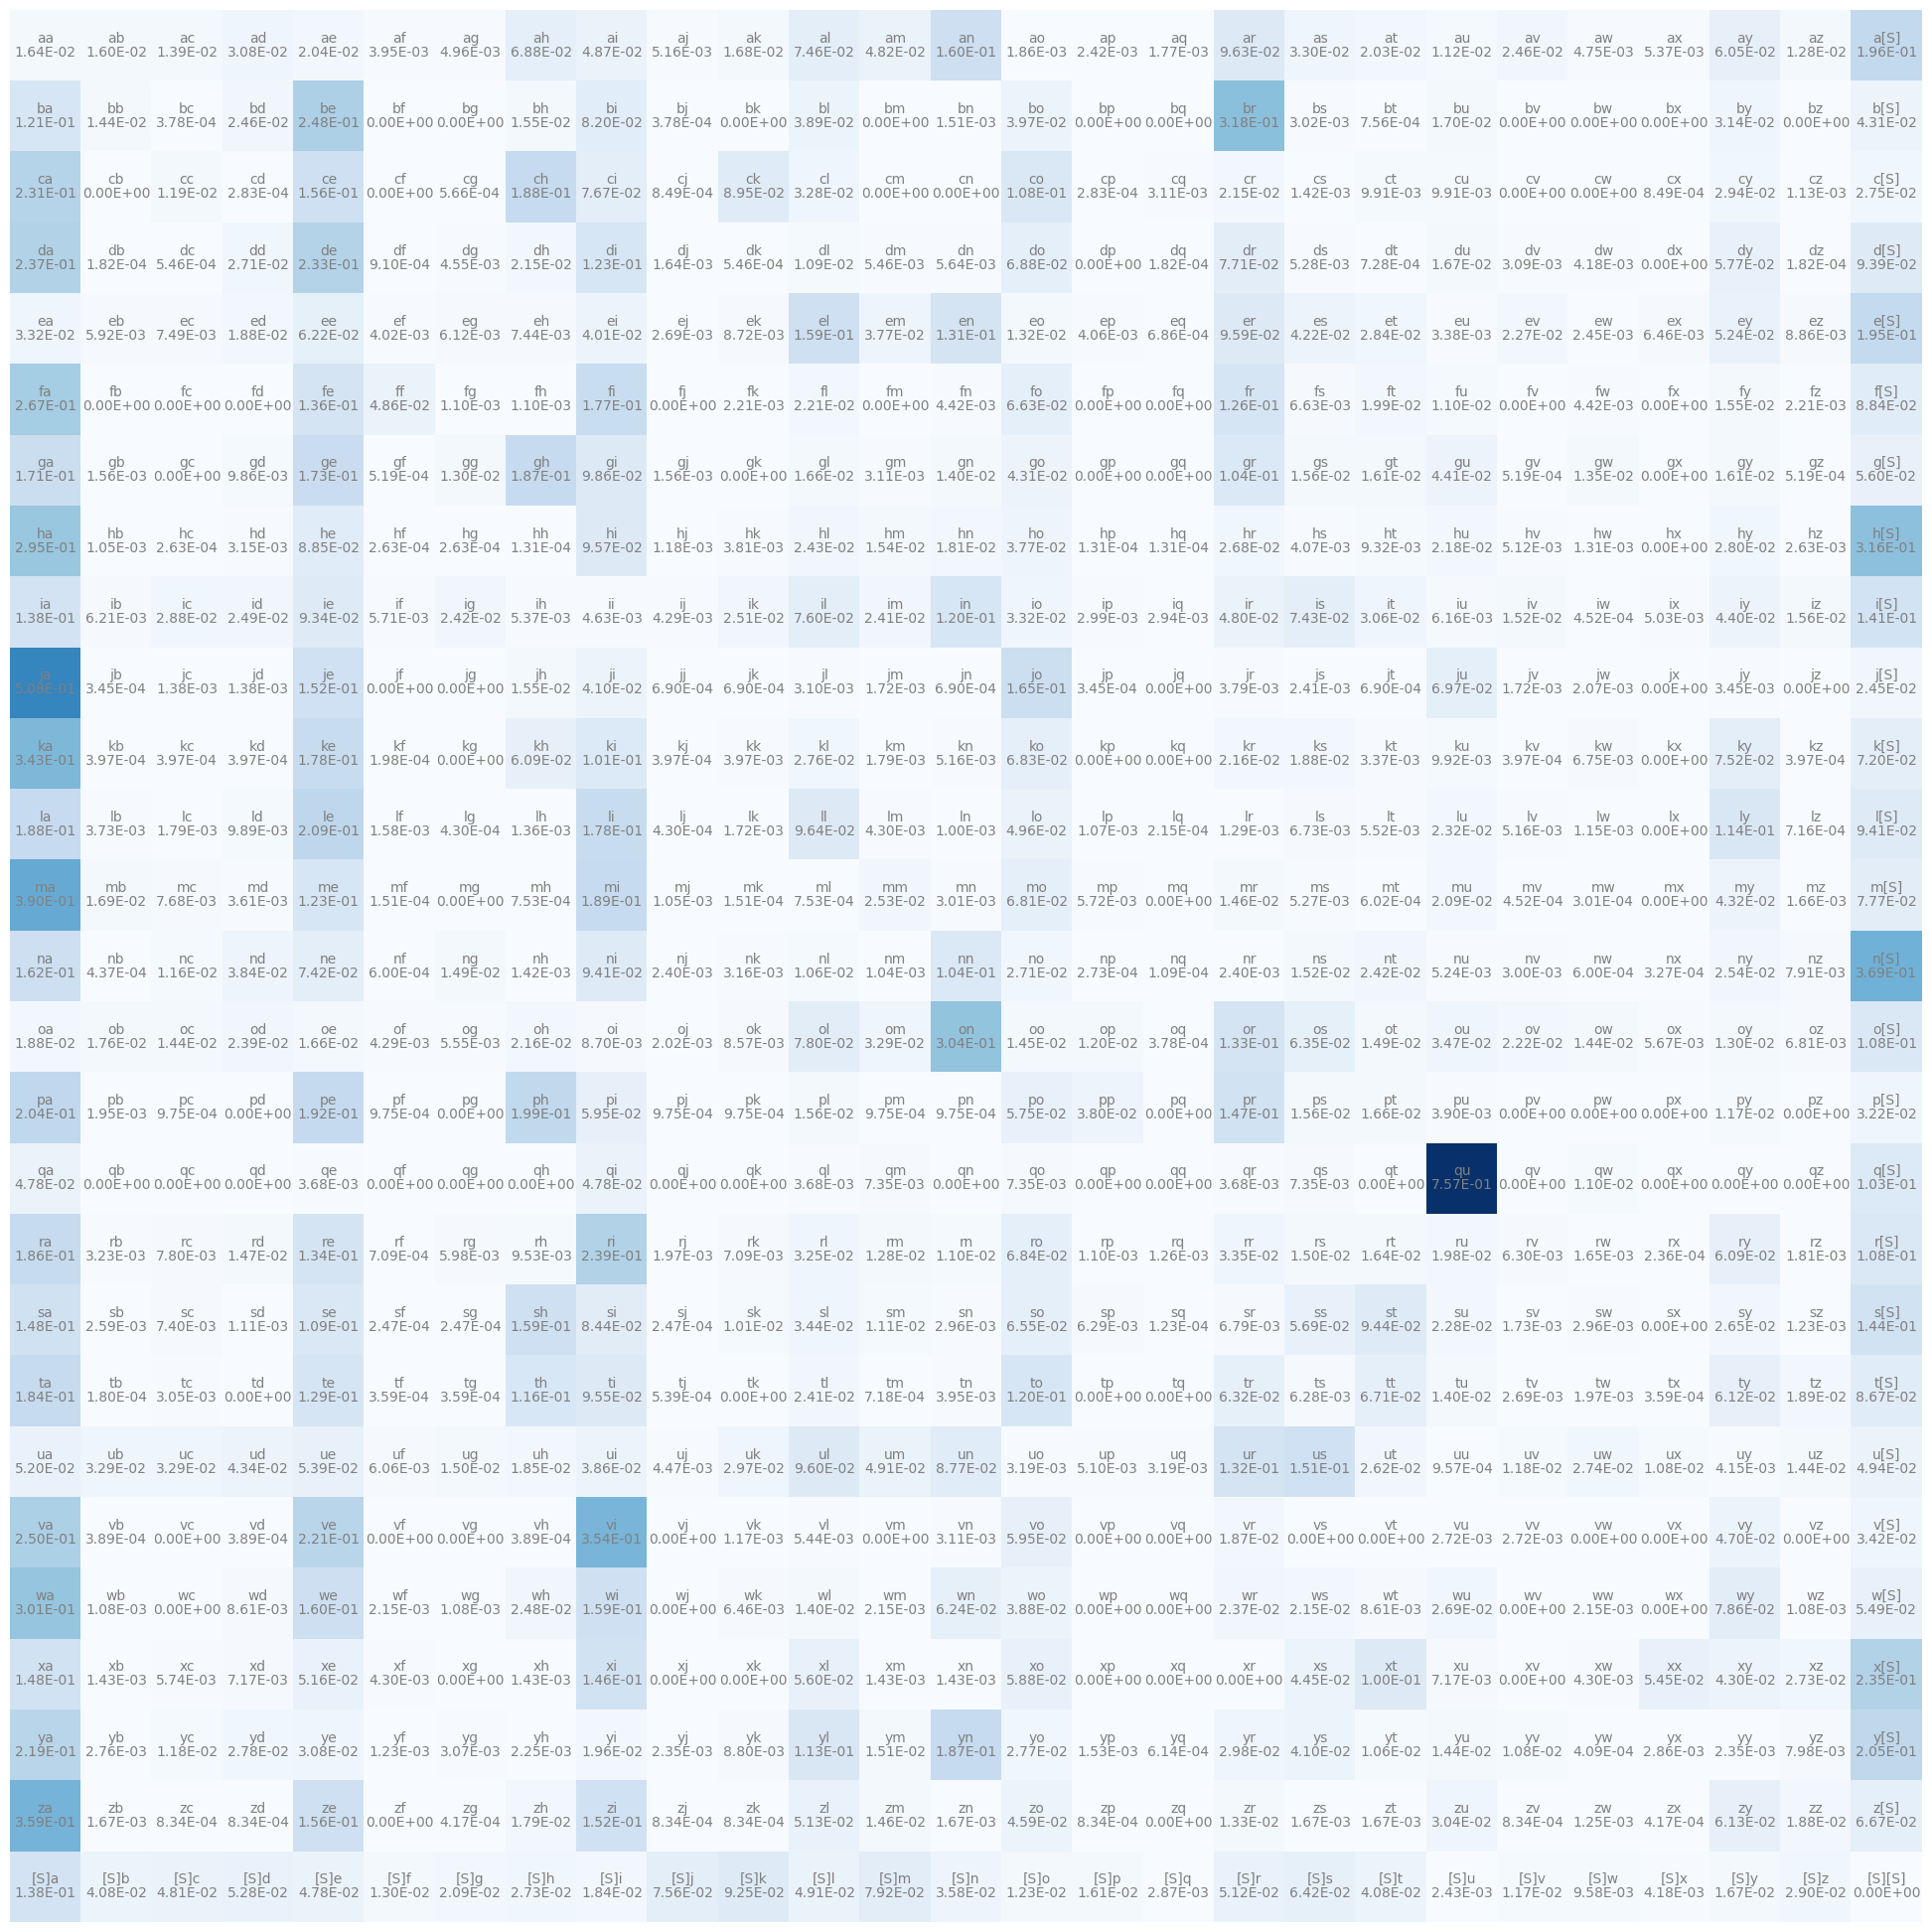

In [5]:
# Visualize the probabilities
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25,25))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = index_to_char[i] + index_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, '%.2E' % P[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.savefig('bigram_table.png', dpi=300)

Questions
- Which token is most likely to start a sequence?
- Which token is most likely to end a sequence?
- Which token is most likely to follow token `v`?
- Which token pair has the highest probability according to the model?

### Generating with the bigram model

Now we can generate sequences using the bigram model. We will denote the model as $p_\theta$, where $\theta$ are the parameters of the model (i.e., the transition probabilities).

First, let's generate some first-tokens:

\begin{align*}
    x_1\sim p_\theta(\cdot|x_0)
\end{align*}

In [5]:
index = torch.multinomial(
    P[char_to_index['[S]']], 
    num_samples=10,
    replacement=True
)

[index_to_char[i.item()] for i in index]

['m', 'm', 'b', 's', 'm', 'b', 'k', 'a', 'a', 'e']

To generate full sequences, we will start with the `[S]` token and iteratively sample the next token based on the current token's distribution. This process will continue until we sample the `[S]` token again, indicating the end of the sequence.

Here is the step-by-step process:

1. Start with the `[S]` token.
2. Sample the next token based on the current token's distribution.
3. Append the sampled token to the sequence.
4. Use the sampled token as the new current token.
5. Repeat steps 2-4 until the `[S]` token is sampled again.

Let's implement this in the next code cell.

In [9]:
def generate_sequence():
    sequence = ['[S]']
    while True:
        current_char = sequence[-1]
        current_index = char_to_index[current_char]
        next_index = torch.multinomial(P[current_index], num_samples=1).item()
        next_char = index_to_char[next_index]
        if next_char == '[S]':
            break
        sequence.append(next_char)
    return ''.join(sequence[1:])

# Generate 10 sequences
generated_sequences = [generate_sequence() for _ in range(10)]
generated_sequences

['lere',
 'anarusahafeleeyaricky',
 'bamie',
 'mcee',
 'ka',
 'ar',
 'tayliannelyan',
 'jayl',
 'kyn',
 'kiy']

Although the model is clearly not that good at generating new sequences (names), let's compare it to just uniformly sampling characters.

In [10]:
import random

def generate_uniform_sequence():
    characters = list(char_to_index.keys())
    sequence = ['[S]']
    while True:
        next_char = random.choice(characters)
        if next_char == '[S]':
            break
        sequence.append(next_char)
    return ''.join(sequence[1:])

# Generate 10 sequences
uniform_sequences = [generate_uniform_sequence() for _ in range(10)]
uniform_sequences

['tvctogdsvzsu',
 'truhheppqpqigqljvtflwpcjtx',
 'owehecifbytna',
 'zqxqdc',
 'vunmckiploqqkampovkiglgkasy',
 'qqfxtolkmsiqqlrndwefrvpeytdber',
 '',
 'zbxdrtfslswe',
 'kkdzejpoauylbrdeyxxjbzikmvatjijnufmndszx',
 'lgjtvpocjpfdtirw']

The bigram model clearly has a bit more structure than this uniform baseline.

### Evaluating the model using log-likelihood and perplexity
To evaluate the model, we can compute the **log-likelihood** of sequences in a dataset. The log-likelihood of a sequence is given by:

\begin{align*}
\log p(x_1, x_2, \ldots, x_T) = \sum_{t=1}^{T} \log p(x_t \mid x_{t-1})
\end{align*}

where $ p(x_t \mid x_{t-1}) $ is the conditional probability of token $ x_t $ given the previous token $ x_{t-1} $. We use log probabilities to avoid numerical underflow when multiplying many probabilities together.

In [8]:
def log_likelihood(P, dataset):
    n = 0
    ll = 0
    for x in dataset:
        sequence = ['[S]'] + list(x) + ['[S]']
        for x1, x2 in zip(sequence, sequence[1:]):
            i = char_to_index[x1]
            j = char_to_index[x2]
            ll += torch.log(P[i, j])
            n += 1
    return ll, n

ll, n = log_likelihood(P, data)
print(f'Log likelihood: {ll.item():.4f}')
print(f'Average next-token log likelihood {ll.item() / n:.4f}')

Log likelihood: -559891.7500
Average next-token log likelihood -2.4541


It is common to report log-likelihood in terms of **perplexity**, which is defined on a per-token basis as:

\begin{align*}
\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log p(x_i \mid x_{i-1})\right)
\end{align*}

where $N$ is the total number of tokens in the dataset. Lower perplexity indicates a better model.

Check this great [blog post](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/) for more details about perplexity and related quantities in language models.

In [9]:
def perplexity(model, dataset):
    ll, n = log_likelihood(model, dataset)
    return torch.exp(-ll / n).item()

perplexity(P, data)

11.635889053344727

#### Evaluating on held-out data (suggested exercise 1)

Above we evaluated the model on the training data. To evaluate generalization, we want to evaluate on a held-out set of sequences.

In this simple example, we did not hold out a set of test names. As an exercise, you can partition the dataset into training, validation, and test sequences, and evaluate the held-out validation and/or test perplexity.

A key consideration is that our model may assign **zero probability** to a sequence that it did not see in training, hence resulting in unbounded log-likelihood. To overcome this, you can implement **uniform smoothing** as described in the lecture. Namely, we add a fixed probability mass $\alpha$ to each next-token probability. 

**Suggested exercise 2:** generalize the model above to an $n$-gram model (e.g., n = 2, 3, 4, ...)

## A simple neural bigram model

Next we will frame the above model in terms of **learning** a model, i.e. $p(\cdot|x_{t-1})=W x_{t-1}$.


In [10]:
# Make a training set
xs, ys = [], []
for x in data:
    sequence = ['[S]'] + list(x) + ['[S]']
    for x1, x2 in zip(sequence, sequence[1:]):
        xs.append(char_to_index[x1])
        ys.append(char_to_index[x2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [11]:
xs[:10], ys[:10]

(tensor([26,  4, 12, 12,  0, 26, 14, 11,  8, 21]),
 tensor([ 4, 12, 12,  0, 26, 14, 11,  8, 21,  8]))

In [12]:
torch.nn.functional.one_hot(xs, num_classes=27)[:3]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [13]:
# W_ij is the probability of character j given character i
W = torch.randn(27, 27, requires_grad=True)
learning_rate = 20

def forward(x):
    xenc = torch.nn.functional.one_hot(x, num_classes=27).float()
    logits = xenc.matmul(W) # dim: (batch_size, 27)
    return logits

def nll_loss(logits, y):
    loss = -torch.nn.functional.log_softmax(logits, dim=1) # dim: (batch_size, 27)
    loss = loss[range(len(y)), y] # dim: (batch_size,)
    loss = loss.mean()
    return loss

for k in range(1000):
    logits = forward(xs)
    nll = nll_loss(logits, ys)
    loss = nll 

    W.grad = None
    loss.backward()
    if k % 100 == 0:
        print(loss.item())

    W.data -= learning_rate * W.grad


3.709355592727661
2.510594129562378
2.4799652099609375
2.4702765941619873
2.4656450748443604
2.4629650115966797
2.4612250328063965
2.4600107669830322
2.459122896194458
2.4584498405456543


Log likelihood: -560796.0000
Average next-token log likelihood -2.4581


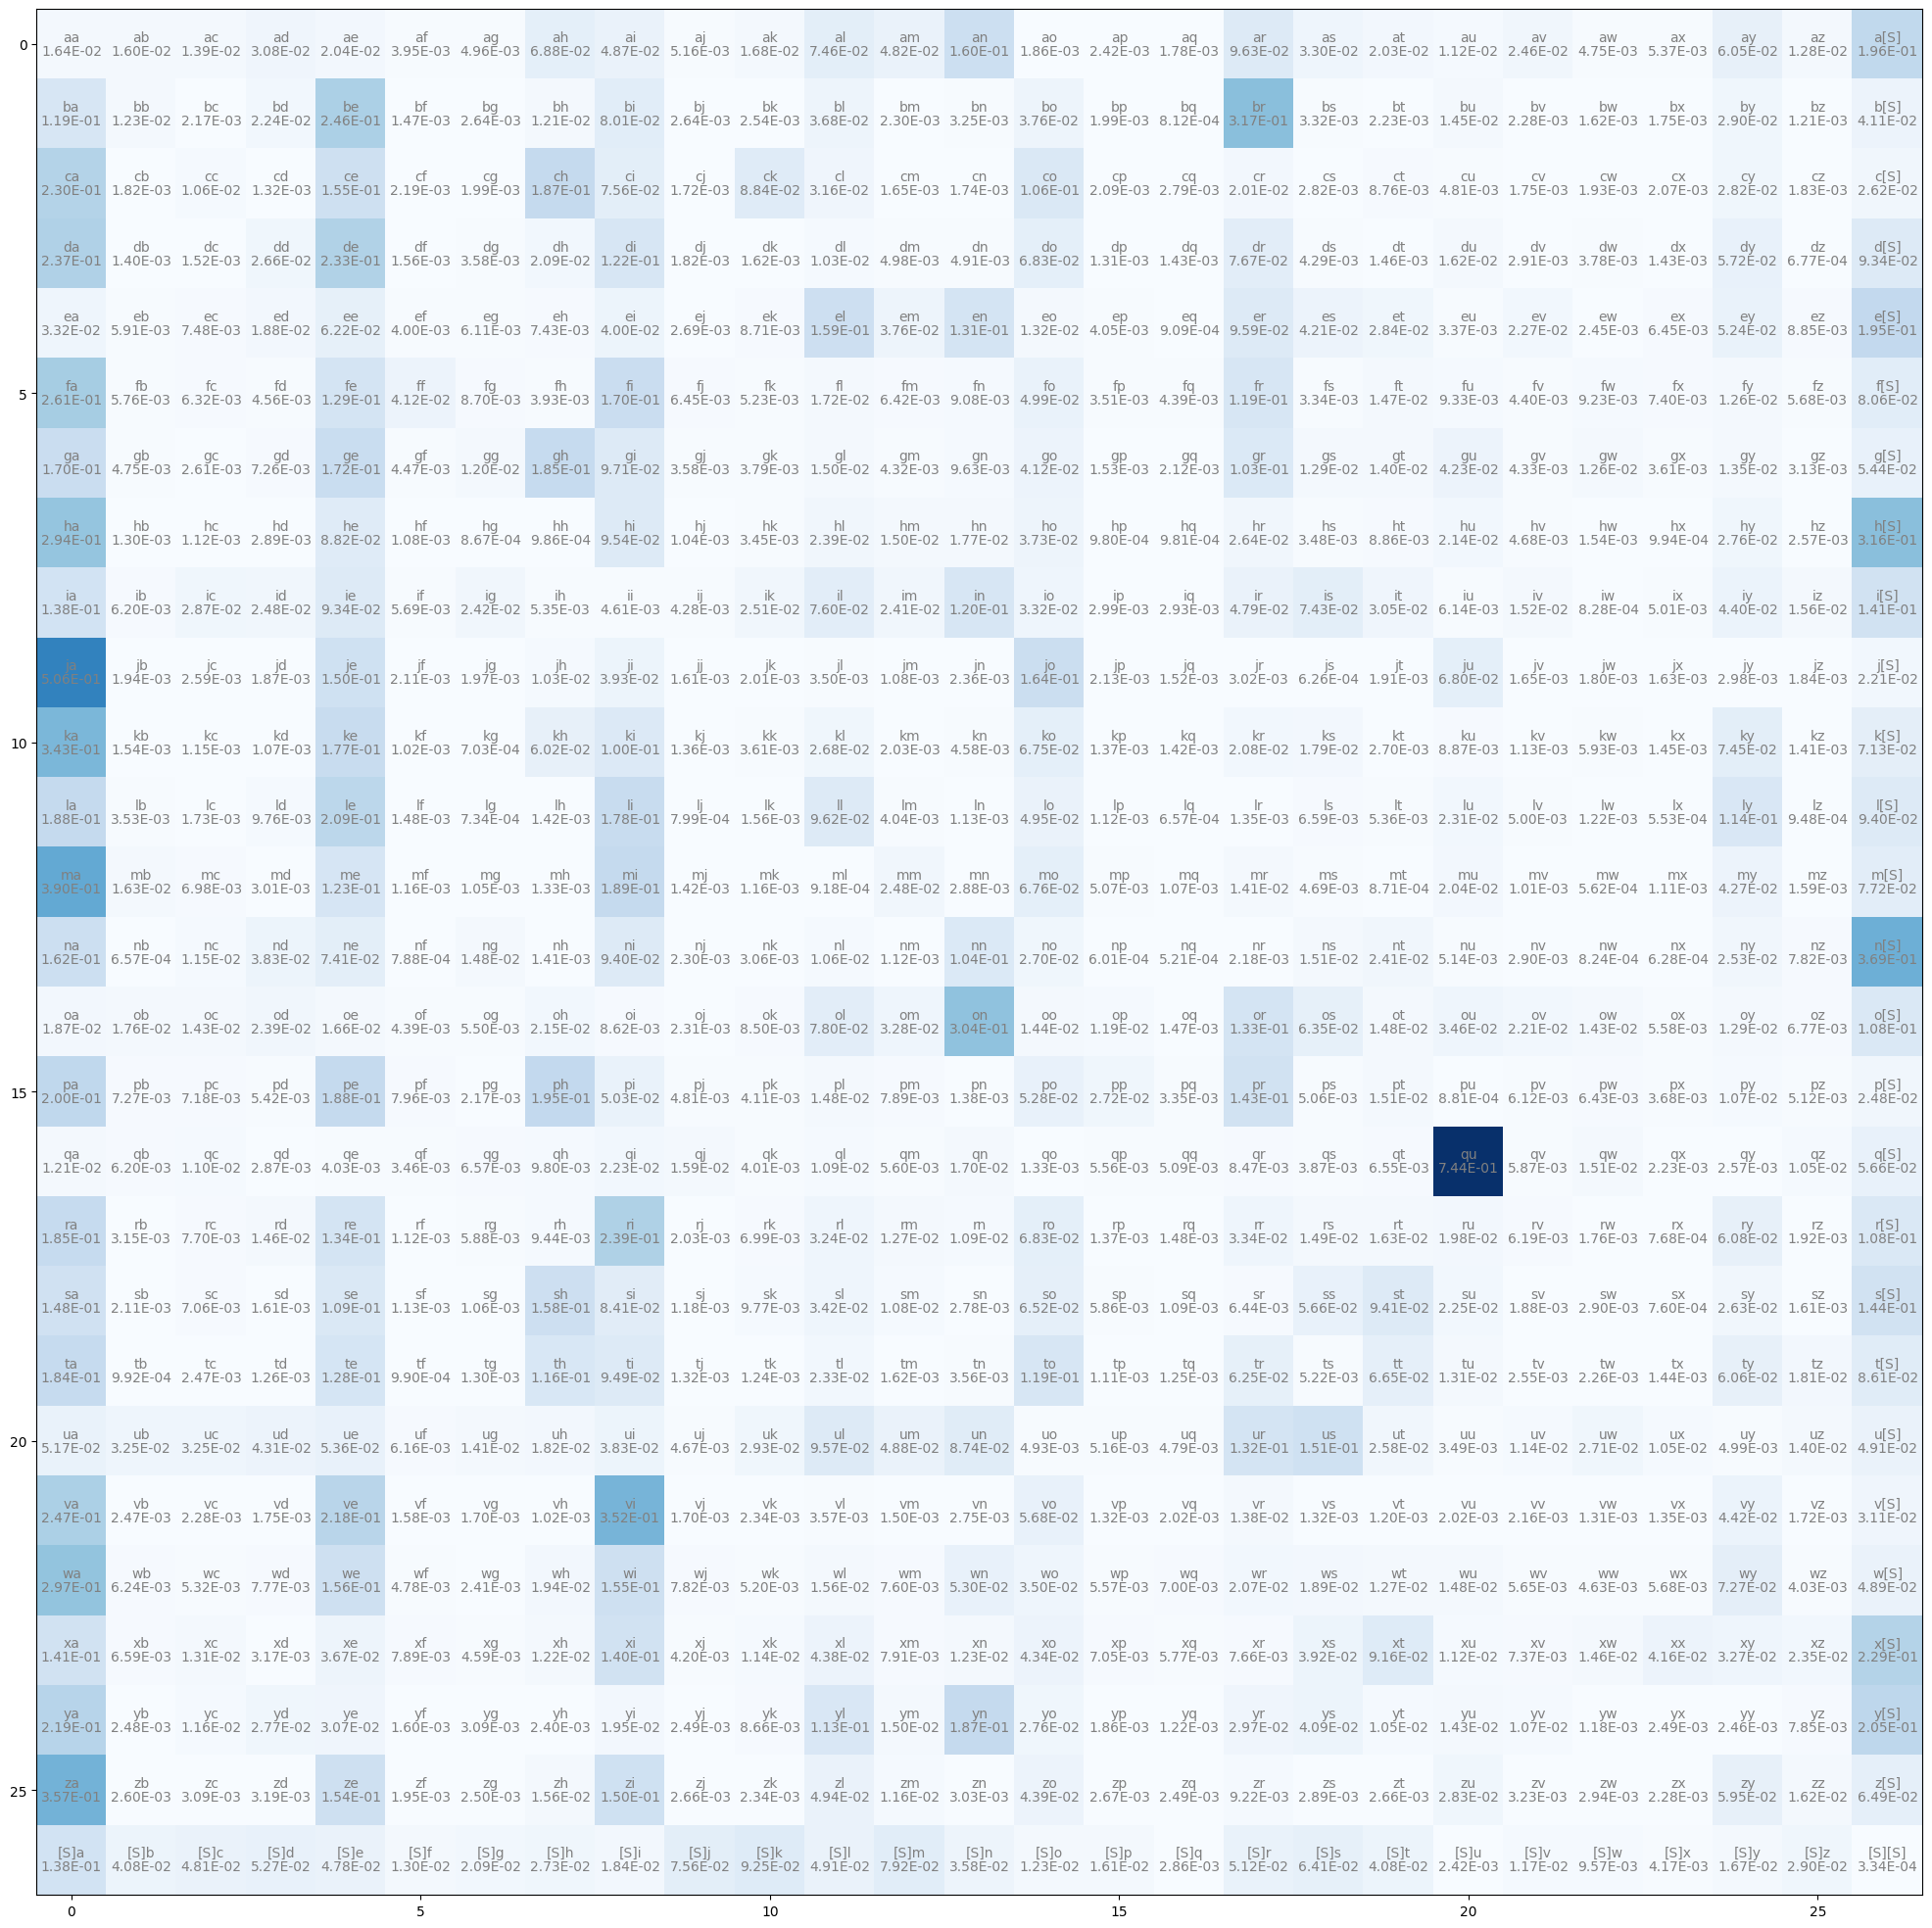

In [14]:
# Visualize the model's probabilities
P_ = torch.nn.functional.softmax(W, dim=1).detach()

ll, n = log_likelihood(P_, data)
print(f'Log likelihood: {ll.item():.4f}')
print(f'Average next-token log likelihood {ll.item() / n:.4f}')

plt.figure(figsize=(25,25))
plt.imshow(P_.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = index_to_char[i] + index_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, '%.2E' % P_[i, j].item(), ha="center", va="top", color='gray')

Questions
- Which token is most likely to start a sequence?
- Which token is most likely to end a sequence?
- Which token is most likely to follow token `v`?
- Which token pair has the highest probability according to the model?

We can see that our simple learned model is quite similar to the one that was based on word counts.

In the next notebooks, we will build better neural networks that improve the ability to model and generate sequences.